# Lion-Q-VQE
## Greatest Minimum Variance Portfolio (GMVP)

In [3]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_algorithms
!pip install qiskit_finance
!pip install scienceplots

### Imports

In [5]:
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, EfficientSU2
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient, SPSAEstimatorGradient, LinCombEstimatorGradient, ParamShiftEstimatorGradient, ParamShiftSamplerGradient, QFI, DerivativeType, LinCombQGT
from qiskit_optimization.translators import from_docplex_mp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import scienceplots

# Create a portfolio instance using PortfolioOptimization

In [7]:
# set number of assets which is equal to number of qubits
num_assets = 25
seed = 479

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

risk_factor = 0.5  # set risk factor
budget = 20  # set budget

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()

# Classical Monte Carlo Simulation

In [9]:
# Portfolio optimization
best_portfolio = None
best_return = -np.inf

# Lists to store results for plotting
returns_list = []
risks_list = []

# Iterate over random portfolio allocations
for _ in range(10000):  # Try 10,000 random allocations
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    scaled_weights = weights * budget # Scale weights to fit the budget

    # Calculate portfolio return and risk
    portfolio_return = np.dot(scaled_weights, ev)  # Expected return
    portfolio_risk = np.dot(scaled_weights.T, np.dot(covariance, scaled_weights))  # Variance or RISK!!
    portfolio_std_dev = np.sqrt(portfolio_risk)  # Standard deviation

    # Calculate the adjusted return based on risk (weighted by risk_factor)
    adjusted_return = portfolio_return - risk_factor * portfolio_risk

    ## Store the results for plotting
    returns_list.append(portfolio_return)
    risks_list.append(portfolio_risk)

    ## Best Portfolio Tracking
    # Select the best portfolio based on the highest expected return
    if adjusted_return > best_return:
        best_return = adjusted_return
        best_portfolio = scaled_weights
    ########################################

# Calculate expected return of the best portfolio
expected_return_best_portfolio = np.dot(best_portfolio, ev)

# Print results
print("Best Portfolio Allocation (scaled to budget):", best_portfolio)
print(f"\nExpected Return of Best Portfolio: {expected_return_best_portfolio:.4%}")
print("Risk of Best Portfolio:", np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)))

Best Portfolio Allocation (scaled to budget): [1.3168327  1.1208904  0.2778668  0.89158178 0.48388253 1.57393941
 0.40882803 0.45485693 0.83070023 0.63661381 0.07260758 1.16426708
 0.43288391 1.34861053 1.16698833 1.3951458  1.58609423 0.81749436
 0.35608704 0.04222942 0.26268154 1.38662079 0.26878718 1.62185861
 0.08165097]

Expected Return of Best Portfolio: 10.0878%
Risk of Best Portfolio: 0.1273802867857253


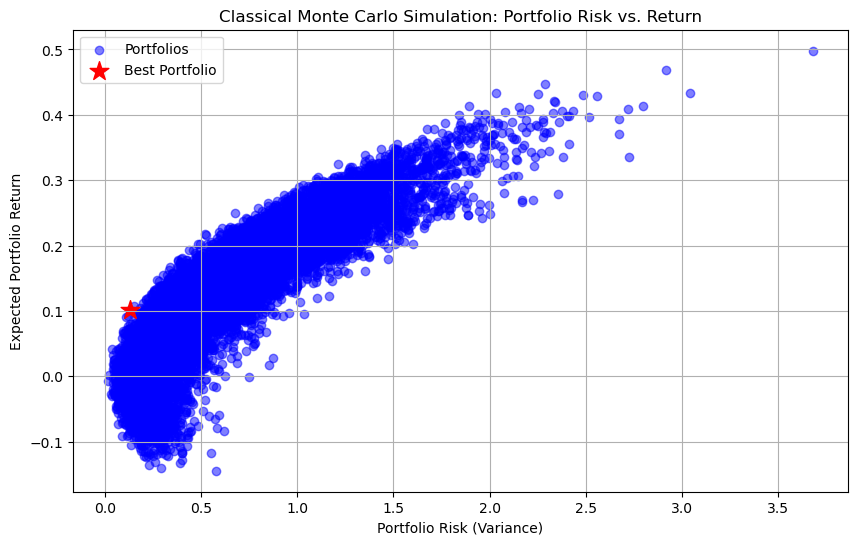

In [10]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Portfolios')
plt.scatter(np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)), np.dot(ev, best_portfolio),
            color='red', marker='*', s=200, label='Best Portfolio')
plt.title('Classical Monte Carlo Simulation: Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid()
plt.show()

### Global Minimum-Variance Portfolio (GMVP)

In [12]:
from scipy.optimize import minimize



GMVP Weights (scaled to budget): [1.02652615 0.95667758 1.01374508 1.00403987 0.94206605 0.99762256
 0.01274272 1.01433397 1.07882557 0.092016   1.00421664 0.98645897
 1.03660473 0.96722464 1.00195748 1.00704283 1.03551401 0.96782747
 0.02901428 0.         0.         1.00484405 0.94075794 0.87072142
 1.00922   ]

Expected Return of GMVP: -0.0641%
Risk of GMVP: 0.00889618731780511


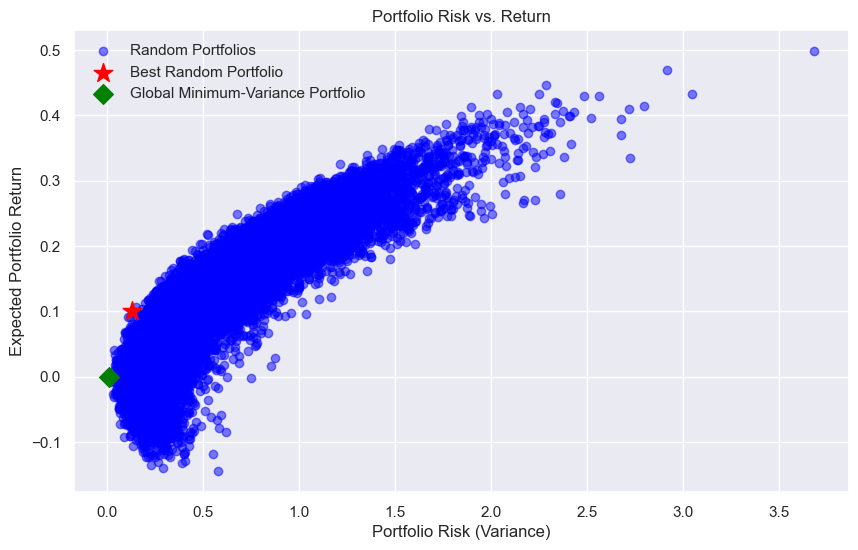

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl


# -------------------------------
# Compute the Global Minimum-Variance Portfolio (GMVP)
# -------------------------------

# Define the portfolio variance function to minimize
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: Sum of weights equals 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: Weights between 0 and 1 (long-only constraint)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess: Equal weights
initial_guess = num_assets * [1.0 / num_assets]

# Optimize to find the GMVP weights
result = minimize(
    portfolio_variance,
    initial_guess,
    args=(covariance,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract the GMVP weights
gmvp_weights = result.x

# Calculate GMVP return and risk
gmvp_return = np.dot(gmvp_weights, ev) * budget  # Scale by budget
gmvp_variance = portfolio_variance(gmvp_weights * budget, covariance)  # Scale weights
gmvp_std_dev = np.sqrt(gmvp_variance)

print("\nGMVP Weights (scaled to budget):", gmvp_weights * budget)
print(f"\nExpected Return of GMVP: {gmvp_return:.4%}")
print("Risk of GMVP:", gmvp_variance)


# -------------------------------
# Plotting the results
# -------------------------------

# Reset all Matplotlib settings to default
mpl.rcParams.update(mpl.rcParamsDefault)

# Disable LaTeX rendering explicitly
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'  # Use DejaVu Sans instead of LaTeX

# Re-apply desired styles that don't require LaTeX
plt.style.use('seaborn-v0_8-darkgrid')  # Alternative style without LaTeX dependency
sns.set()

# Your plotting code
plt.figure(figsize=(10, 6))

# Scatter plot of random portfolios
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Random Portfolios')

# Plot the Best Portfolio from Random Sampling
plt.scatter(
    np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)),
    np.dot(ev, best_portfolio),
    color='red',
    marker='*',
    s=200,
    label='Best Random Portfolio'
)

# Plot the GMVP
plt.scatter(
    gmvp_variance,
    gmvp_return,
    color='green',
    marker='D',
    s=100,
    label='Global Minimum-Variance Portfolio'
)

plt.title('Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()

### Minimum Eigensolver

In [27]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

In [29]:
#classical optimizer
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)  # if x_n = 1.0 : buy, if x_n = 0.0 : do not buy

fval=-0.0018984848782011912, x_0=1.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=0.0, x_8=1.0, x_9=1.0, x_10=1.0, x_11=1.0, x_12=1.0, x_13=1.0, x_14=1.0, x_15=1.0, x_16=1.0, x_17=1.0, x_18=0.0, x_19=0.0, x_20=0.0, x_21=1.0, x_22=1.0, x_23=1.0, x_24=1.0, status=SUCCESS


In [30]:
# Extract optimal weights
optimal_weights = result.x

expected_return_optimal = np.dot(optimal_weights, ev)

# Print results
print("Optimal Portfolio Allocation (scaled to budget):", optimal_weights )#* budget)
print(f"\nExpected Return of Optimal Portfolio: {expected_return_optimal:.4%}")
print("Risk of Optimal Portfolio:", np.dot(optimal_weights.T, np.dot(covariance, optimal_weights)))

Optimal Portfolio Allocation (scaled to budget): [1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1.]

Expected Return of Optimal Portfolio: 2.0669%
Risk of Optimal Portfolio: 0.03754046707115206


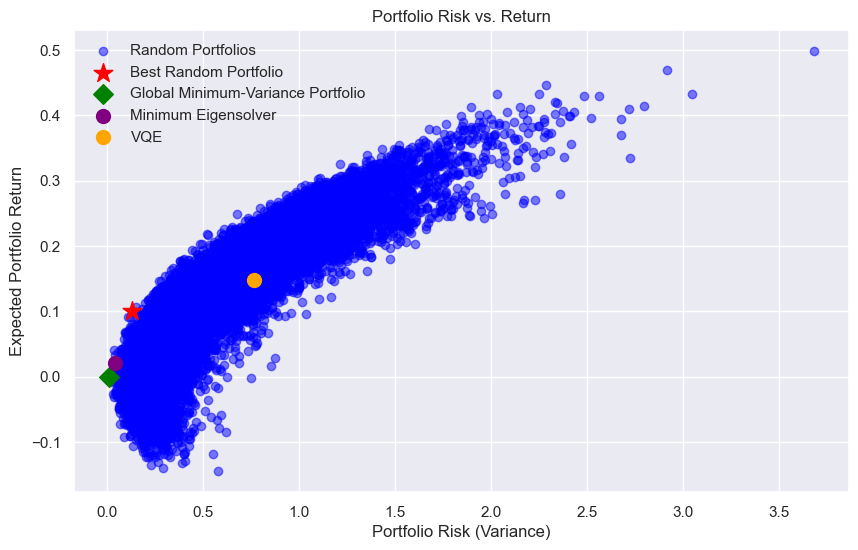

In [35]:
optimal_risk = np.dot(optimal_weights.T, np.dot(covariance, optimal_weights))  # Calculate risk of the optimal portfolio
optimal_return = np.dot(optimal_weights, ev)  # Calculate expected return of the optimal portfolio

plt.figure(figsize=(10, 6))

# Scatter plot of random portfolios
plt.scatter(risks_list, returns_list, alpha=0.5, color='blue', label='Random Portfolios')

# Plot the Best Portfolio from Random Sampling
plt.scatter(
    np.dot(best_portfolio.T, np.dot(covariance, best_portfolio)),
    np.dot(ev, best_portfolio),
    color='red',
    marker='*',
    s=200,
    label='Best Random Portfolio'
)

# Plot the GMVP
plt.scatter(
    gmvp_variance,
    gmvp_return,
    color='green',
    marker='D',
    s=100,
    label='Global Minimum-Variance Portfolio'
)

# Plot the Minimum Eigensolver
plt.scatter(
    optimal_risk,
    optimal_return,
    color='purple',  # Different color for distinction
    marker='o',  # Circle marker
    s=100,  # Size of the marker
    label='Minimum Eigensolver'
)

#Plot the VQE
vqe_weights = np.array([1.,1.,1.,1.,1., 1., 1.,0.,1.,1.,1.,1.,0.,1.,0.,1.,1.,1.,1.,1.,1.,1.,1.,0.,0.])
vqe_return = np.dot(vqe_weights, ev)
vqe_risk = np.dot(vqe_weights.T, np.dot(covariance, vqe_weights))
plt.scatter(
    vqe_risk,
    vqe_return,
    color='orange',  # Different color for distinction
    marker='o',  # Circle marker
    s=100,  # Size of the marker
    label='VQE'
)

plt.title('Portfolio Risk vs. Return')
plt.xlabel('Portfolio Risk (Variance)')
plt.ylabel('Expected Portfolio Return')
plt.legend()
plt.grid(True)
plt.show()